In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from ssm.plots import gradient_cmap
import plotly.graph_objects as go
from IPython.display import HTML , display
from plotly import tools
from ARHMM_plots import *
from matplotlib import cm
import plotly.express as px

In [2]:
def rgb_to_hex(rgb):
    return f'#{int(rgb[0]*256):02x}{int(rgb[1]*256):02x}{int(rgb[2]*256):02x}'

def triangulate_histogram(x, y, z):

    if len(x)  != len(y) != len(z) :
        raise ValueError("The  lists x, y, z, must have the same length")
    n = len(x)
    
    if n % 2 :
        raise ValueError("The length of lists x, y, z must be an even number") 
    
    pts3d = np.vstack((x, y, z)).T
    pts3dp = np.array([[x[2*k+1], y[2*k+1], 0] for k in range(1, n//2-1)])
    pts3d = np.vstack((pts3d, pts3dp))
    
    #triangulate the histogram bars:
    tri = [[0,1,2], [0,2,n]]
    
    for k, i  in zip(list(range(n, n-3+n//2)), list(range(3, n-4, 2))):
        tri.extend([[k, i, i+1], [k, i+1, k+1]])
        
    tri.extend([[n-3+n//2, n-3, n-2], [n-3+n//2, n-2, n-1]])      
    
    return pts3d, np.array(tri)

def make_histogram_projections(fig,newdf,fig_row,fig_col,bar_color='#e763fa',bins=50):

    # data binning and traces
    col = 'bl'
    a0_bl=np.histogram(newdf[col], bins=bins, density=False)[0].tolist()
    a0_bl=np.repeat(a0_bl,2).tolist()
    a0_bl.insert(0,0)
    a0_bl.pop()
    a0_bl[-1]=0
    a1_bl=np.histogram(newdf[col], bins=bins-1, density=False)[1].tolist()
    a1_bl=np.repeat(a1_bl,2)

    verts, tri = triangulate_histogram([ranges['zmin']]*len(a0_bl), a1_bl, a0_bl / np.max(a0_bl))
    x_bl, y_bl, z_bl = verts.T
    I_bl, J_bl, K_bl = tri.T


    col = 'yaw'
    a0_yaw=np.histogram(newdf[col], bins=bins, density=False)[0].tolist()
    a0_yaw=np.repeat(a0_yaw,2).tolist()
    a0_yaw.insert(0,0)
    a0_yaw.pop()
    a0_yaw[-1]=0
    a1_yaw=np.histogram(newdf[col], bins=bins-1, density=False)[1].tolist()
    a1_yaw=np.repeat(a1_yaw,2)

    verts, tri = triangulate_histogram([ranges['xmin']]*len(a0_yaw), a1_yaw, a0_yaw / np.max(a0_yaw))
    x_yaw, y_yaw, z_yaw = verts.T
    I_yaw, J_yaw, K_yaw = tri.T

    col = 'speed'

    a0_speed=np.histogram(newdf[col], bins=bins, density=False)[0].tolist()
    a0_speed=np.repeat(a0_speed,2).tolist()
    a0_speed.insert(0,0)
    a0_speed.pop()
    a0_speed[-1]=0
    a1_speed=np.histogram(newdf[col], bins=bins-1, density=False)[1].tolist()
    a1_speed=np.repeat(a1_speed,2)

    verts, tri = triangulate_histogram([ranges['ymin']]*len(a0_speed), a1_speed, a0_speed / np.max(a0_speed))
    x_speed, y_speed, z_speed = verts.T
    I_speed, J_speed, K_speed = tri.T

    newranges = {
        'xmin':np.min(newdf['speed']),
        'xmax':np.max(newdf['speed']),
        'ymin':np.min(newdf['bl']),
        'ymax':np.max(newdf['bl']),
        'zmin':np.min(newdf['yaw']),
        'zmax':np.max(newdf['yaw'])
                }

    # Speed
    fig.add_traces(go.Mesh3d(x=newranges['xmin'] + (y_speed - np.min(y_speed))/(np.max(y_speed) - np.min(y_speed))*(newranges['xmax'] - newranges['xmin']), 
                             y=ranges['ymin'] + z_speed/np.max(z_speed)*(ranges['ymax'] - ranges['ymin'])*0.5, 
                             z=x_speed/np.max(x_speed)*ranges['zmin'], 
                             i=I_speed, j=J_speed, k=K_speed, color=bar_color, opacity=0.7),rows=[fig_row], cols=[fig_col])

    # Body length
    fig.add_traces(go.Mesh3d(x=x_bl/np.max(x_bl)*ranges['xmin'], 
                             y=newranges['ymin'] + (y_bl - np.min(y_bl))/(np.max(y_bl) - np.min(y_bl))*(newranges['ymax'] - newranges['ymin']), 
                             z=ranges['zmin'] + z_bl/np.max(z_bl)*(ranges['zmax'] - ranges['zmin'])*0.5, 
                             i=I_bl, j=J_bl, k=K_bl, color=bar_color, opacity=0.7),rows=fig_row, cols=fig_col)

    # Yaw
    fig.add_traces(go.Mesh3d(x=ranges['xmin'] + z_yaw/np.max(z_yaw)*(ranges['xmax'] - ranges['xmin'])*0.5, 
                             y=ranges['ymin']*x_yaw/np.max(x_yaw), 
                             z=newranges['zmin'] + (y_yaw - np.min(y_yaw))/(np.max(y_yaw) - np.min(y_yaw))*(newranges['zmax'] - newranges['zmin']), 
                             i=I_yaw, j=J_yaw, k=K_yaw, color=bar_color, opacity=0.7),rows=fig_row, cols=fig_col)

    return fig

In [3]:

data_csv = r'c:\Users\magnu\OneDrive\Dokument\KI\KI2020\New_data_201120\Mouse_frans\20201120_behaviour2020_v_frans_1_pose_data.csv'
vid_name = r'c:\Users\magnu\OneDrive\Dokument\KI\KI2020\New_data_201120\Mouse_frans\20201120_behaviour2020_v_frans_1_recordingDLC_resnet50_KI2020_TrainingSep19shuffle1_400000_labeled.mp4'

interval_start = 3500
interval_end = 37755
div = 1

ARHMM_kwargs={  'kappa':1,
                'use_best_K':True, 
                'K':None,
                'epochs':20,
                'start_K':1,
                'end_K':5}

make_vid=True
smooth=True
box_size=0.6
box_pixel=400
T=2e-3
d=5
seed=1


timestr = time.strftime("%Y%m%d-%H%M%S")
p = os.path.normpath(data_csv)
newpath = os.sep.join([os.sep.join(p.split(os.sep)[:-1]), 'results',timestr])

Path(newpath).mkdir(parents=True, exist_ok=True)

interval = range(interval_start,interval_end,div)

df = pd.read_csv(data_csv)


In [4]:

preproc_data , speed , head_body_angle , body_len = preprocess_data(df, interval, div, smooth, box_size, box_pixel, d, T)

hmm , best_K , num_states , val_lls , train_lls , best_val_lls , best_train_lls = produce_ARHMM_data(preproc_data, ARHMM_kwargs, seed)

hmm_z = hmm.most_likely_states(preproc_data,)

print(f'Best K: {best_K}')

C:\Users\magnu\OneDrive\Dokument\KI\KI2020\Analysis\ARHMM_utils.py:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\magnu\OneDrive\Dokument\KI\KI2020\Analysis\ARHMM_utils.py:98: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of outliers removed: 4223 (0.12329567019941023 %)


ValueError: too many values to unpack (expected 4)

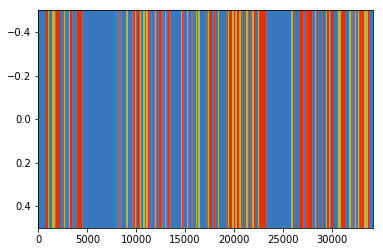

In [5]:

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"

    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

im = plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=max(hmm_z) + 1)
plt.show()

values = np.unique(hmm_z)
colors = [ im.cmap(im.norm(value))[:-1] for value in values ]

df = pd.DataFrame(data={'state':hmm_z,'speed':speed,'bl':body_len,'yaw':head_body_angle})

df['state_consec'] = (df.state.diff(1) != 0).astype('int')

df['state_appearence'] = df.groupby('state')['state_consec'].cumsum()

df['u'] = df.speed.diff(1)
df['v'] = df.bl.diff(1)
df['w'] = df.yaw.diff(1)

df['norms'] = np.sqrt(df['u']**2 + df['v']**2 + df['w']**2)

max_appearence = max(df['state_appearence'])
state_values = np.unique(df['state_appearence'])



ModuleNotFoundError: No module named 'cmocean'

In [50]:

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"

    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

state_colors = [rgb_to_hex(cmap(value/np.max(values))[:-1]) for value in values ]

# Make 3D scatter plot with all variables
ranges = {
    'xmax':max(df['speed']),
    'xmin':min(df['speed']),
    'ymax':max(df['bl']),
    'ymin':min(df['bl']),
    'zmax':max(df['yaw']),
    'zmin':min(df['yaw'])}

titles = {'x':'Speed (m/sec)' ,
         'y':'Body length (m)',
         'z':'Yaw (degrees)'}

n = len(values)
ncols = 3
nrows = n // ncols + 1

cmap_trace = cm.get_cmap('CMRmap')

#colors = sns.xkcd_palette(color_names)
#cmap = gradient_cmap(colors)

specs = [[{'is_3d':True} for _ in range(ncols)] for _ in range(nrows)]
fig = make_subplots(
    rows=nrows, cols=ncols,
    specs=specs,
     vertical_spacing=0.0001,
    horizontal_spacing=0.05)

# Plotting tracjectories

# For each state
for i,k in enumerate(values):
    newdf = df[df['state'] == k]
    occurences = np.unique(newdf['state_appearence'])
    curr_row = i // ncols + 1
    curr_col = i % ncols + 1
        
    make_histogram_projections(fig,newdf,curr_row,curr_col,bar_color=state_colors[i])

    print(f'row: {i // ncols} , row: {i % ncols}')
    for occurence in occurences:
        tmpdf = newdf[newdf['state_appearence'] == occurence]

        colors = [ cmap_trace(j/len(tmpdf)) for j in range(len(tmpdf) + 1) ]

        tmpdf['x'] = tmpdf.speed.rolling(2).sum() / 2
        tmpdf['y'] = tmpdf.bl.rolling(2).sum() / 2
        tmpdf['z'] = tmpdf.yaw.rolling(2).sum() / 2

        fig.add_trace(go.Scatter3d(
            x=tmpdf['speed'],
            y=tmpdf['bl'],
            z=tmpdf['yaw'],
            name = f'O:{occurence}',
            mode= 'lines',
            
#           marker = dict(color=colors, size=0,
#                         line=dict(
#                color='Black',
#                width=0
#            )),
            showlegend = False,
            line = dict(color=colors,width=4),
        ),
                     row = curr_row, col = curr_col)
        
        fig.add_trace(go.Scatter3d(
            x=[tmpdf['speed'].iloc[0]],
            y=[tmpdf['bl'].iloc[0]],
            z=[tmpdf['yaw'].iloc[0]],
            name = f'Start O:{occurence}',
            opacity = 0.7,
            showlegend = False,
            marker = dict(color=colors[0], size=3)
        ),
                     row = curr_row, col = curr_col)
        
        fig.add_trace(go.Scatter3d(
            x=[tmpdf['speed'].iloc[-1]],
            y=[tmpdf['bl'].iloc[-1]],
            z=[tmpdf['yaw'].iloc[-1]],
            name = f'End O:{occurence}',
            opacity = 0.7,
            showlegend = False,
            marker = dict(color=colors[-1], size=3)
        ),
                      row = curr_row, col = curr_col)
        
        
        
        for xyz in ['x','y','z']:
            fig['layout'][f'scene{i+1}'][f'{xyz}axis']['backgroundcolor'] = 'rgb(200,200,230)'
            fig['layout'][f'scene{i+1}'][f'{xyz}axis']['range'] = [ranges[f'{xyz}min'],ranges[f'{xyz}max']]
            fig['layout'][f'scene{i+1}'][f'{xyz}axis']['title'] = titles[xyz]
            fig['layout'][f'scene{i+1}'][f'{xyz}axis']['nticks'] = 8

    
    fig.update_layout(height=1000 , width=1000)

    
        
annotations = tools.make_subplots(rows=nrows, cols=ncols, 
                                  subplot_titles=[f'State {i}' for i in values],
                                  shared_xaxes=True, shared_yaxes=True)['layout']['annotations']

fig['layout'].update(annotations=annotations)


row: 0 , row: 0


C:\Users\magnu\anaconda3\envs\DLC-GPU\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\magnu\anaconda3\envs\DLC-GPU\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\magnu\anaconda3\envs\DLC-GPU\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

row: 0 , row: 1
row: 0 , row: 2
row: 1 , row: 0


Layout({
    'annotations': [{'font': {'size': 16},
                     'showarrow': False,
                     'text': 'State 0',
                     'x': 0.14444444444444446,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'},
                    {'font': {'size': 16},
                     'showarrow': False,
                     'text': 'State 1',
                     'x': 0.5,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'},
                    {'font': {'size': 16},
                     'showarrow': False,
                     'text': 'State 2',
                     'x': 0.8555555555555556,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,


In [51]:
fig.write_html(get_savestr(newpath, f'3d_trajectories_{best_K}','.html'))

In [49]:
cmap_trace = cm.get_cmap('YlGnBu')
cmap_trace(256)

(0.03137254901960784, 0.11372549019607843, 0.34509803921568627, 1.0)

In [3]:
data_csv = r'c:\Users\magnu\OneDrive\Dokument\KTH\2020HT\DD2430_-_Project_Course_in_Data_Science\sharing\New_data_201120\Mouse_2050\20201120_behaviour2020_v_2050_for_frans_1_pose_data.csv'
hmm_csv = r'c:\Users\magnu\OneDrive\Dokument\KTH\2020HT\DD2430_-_Project_Course_in_Data_Science\mouse_data\mouse_data\mouse_2053_20201214-161435\hmm_model_13_states_1_kappa.p'

interval_start = 0
interval_end = 220000
d = 5
div = 10
if interval_end in ['end',-1]:
    interval_end = len(data_frame) - 1

interval = range(interval_start,interval_end)

timestr = time.strftime("%Y%m%d-%H%M%S")
p = os.path.normpath(data_csv)
newpath = os.sep.join([os.sep.join(p.split(os.sep)[:-1]), 'results',timestr])
Path(newpath).mkdir(parents=True, exist_ok=True)


data_frame = pd.read_csv(data_csv)

with open(hmm_csv,'rb') as f:
    hmm = pickle.load(f)

data_to_use , df , speed , head_body_angle , body_len , outliers = preprocess_data(data_frame, interval, div=div, d=d)

interval = np.linspace(interval_start + d,interval_end-len(outliers),len(speed))

hmm_z = hmm.most_likely_states(data_to_use)

df['state'] = hmm_z


C:\Users\magnu\OneDrive\Dokument\KI\KI2020\Analysis\ARHMM_utils.py:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\magnu\OneDrive\Dokument\KI\KI2020\Analysis\ARHMM_utils.py:98: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of outliers removed: 285 (0.012954545454545455 %)


In [4]:

data_frame = pd.read_csv(data_csv)

with open(hmm_csv,'rb') as f:
    hmm = pickle.load(f)

data_to_use , df , speed , head_body_angle , body_len , outliers = preprocess_data(data_frame, interval, div=div, d=d)

interval = np.linspace(interval_start + d,interval_end-len(outliers),len(speed))

hmm_z = hmm.most_likely_states(data_to_use)

df['state'] = hmm_z

Number of outliers removed: 12968 (5.902594446973145 %)


In [5]:
from hmm_3d_trajectories import make_histogram_projections

In [26]:

df['state_consec'] = (df.state.diff(1) != 0).astype('int')

df['state_appearence'] = df.groupby('state')['state_consec'].cumsum()

values = np.unique(df['state'])

color_names = [
"windows blue",
"red",
"amber",
"faded green",
"dusty purple",
"orange",
"dark navy",
"light urple",
"rosa",
"cinnamon",
"bruise",
"dark sage"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

state_colors = [rgb_to_hex(cmap(value/np.max(values))[:-1]) for value in values]

# Make 3D scatter plot with all variables
ranges = {
    'xmax':max(df['speed']),
    'xmin':min(df['speed']),
    'ymax':max(df['bl']),
    'ymin':min(df['bl']),
    'zmax':max(df['yaw']),
    'zmin':min(df['yaw'])}

titles = {'x':'Speed (m/sec)' ,
     'y':'Body length (m)',
     'z':'Yaw (radians)'}

n = len(values)

ncols = 1
nrows = 1

cmap_trace = cm.get_cmap('CMRmap')

specs = [[{'is_3d':True} for _ in range(ncols)] for _ in range(nrows)]

    #vertical_spacing=0.0001,
    #horizontal_spacing=0.05)

#fig.update_layout(height=1000,width=1000)

max_occ = []

for i,k in enumerate(values):
    print(i)
    savename = f'3d_trajectory_{k}.html'
    
    fig = make_subplots(
    rows=nrows, cols=ncols,
    specs=specs)

    newdf = df[df['state'] == k]
    occurences = np.unique(newdf['state_appearence'])
    curr_row = 1
    curr_col = 1

    make_histogram_projections(fig,newdf,ranges,curr_row,curr_col,bar_color=state_colors[i])

    if len(occurences) > 0:
        max_occ.append(max(occurences))
    else:
        max_occ.append(0)

    for occurence in occurences:
        tmpdf = newdf[newdf['state_appearence'] == occurence]

        colors = [ cmap_trace(j/len(tmpdf)) for j in range(len(tmpdf)) ]

        fig.add_trace(go.Scatter3d(
            x=tmpdf['speed'],
            y=tmpdf['bl'],
            z=tmpdf['yaw'],
            name = f'O:{occurence}',
            mode= 'lines',
            showlegend = False,
            line = dict(color=colors,width=4),
            ),
                 row = curr_row, col = curr_col)

        # Add start and end points to each trajectory
        fig.add_trace(go.Scatter3d(
            x=[tmpdf['speed'].iloc[0]],
            y=[tmpdf['bl'].iloc[0]],
            z=[tmpdf['yaw'].iloc[0]],
            name = f'Start O:{occurence}',
            opacity = 0.7,
            showlegend = False,
            marker = dict(color=colors[0], size=3)
            ),
                    row = curr_row, col = curr_col)

        fig.add_trace(go.Scatter3d(
            x=[tmpdf['speed'].iloc[-1]],
            y=[tmpdf['bl'].iloc[-1]],
            z=[tmpdf['yaw'].iloc[-1]],
            name = f'End O:{occurence}',
            opacity = 0.7,
            showlegend = False,
            marker = dict(color=colors[-1], size=3)
            ),
                    row = curr_row, col = curr_col)

    for xyz in ['x','y','z']:
        fig['layout'][f'scene'][f'{xyz}axis']['backgroundcolor'] = 'rgb(200,200,230)'
        fig['layout'][f'scene'][f'{xyz}axis']['range'] = [ranges[f'{xyz}min'],ranges[f'{xyz}max']]
        fig['layout'][f'scene'][f'{xyz}axis']['title'] = titles[xyz]
        #fig['layout'][f'scene'][f'{xyz}axis']['title']['font'] = {'size':5}
        fig['layout'][f'scene'][f'{xyz}axis']['nticks'] = 8
        fig.layout['scene']['camera'] = dict(eye=dict(x=1.7, y=1.7, z=1.7))
    

    annotations = tools.make_subplots(rows=nrows, cols=ncols,
    subplot_titles=[f'State {values[i]} , {max_occ[i]} trajectories']
            )['layout']['annotations']

    fig['layout'].update(annotations=annotations)

    fig.write_html(savename)
    
    name , ext = os.path.splitext(savename)
    newname = name + '.pdf'
    fig.write_image(newname)
    

0
1
2
3
4
5
6
7


In [21]:
fig.layout['scene']['camera'] = dict(
    eye=dict(x=1.6, y=1.6, z=1.6)
)
fig

In [18]:
fig